# Overview

This notebook provides an overview of applying Howso Engine to make predictions based on historical data and harnessing Howso Engine’s interpretability capabilities to understand why the predictions were made. Here, we demonstrate these capabilities on asteroid data. We build a Howso Engine Trainee to predict various information about different asteroids, understand the influential cases on the predictions, and understand the uncertainty of the predictions. This is a straightforward example of the power of Howso Engine to gain insights from data. 

In [1]:
import os

import pandas as pd
import plotly.io as pio

from howso.engine import Trainee
from howso.utilities import infer_feature_attributes
from howso.visuals import plot_interpretable_prediction

pio.renderers.default = os.getenv("HOWSO_RECIPE_RENDERER", "notebook")

# Step 1: Load and Map the Data

## For this demonstration we will use a subset of a dataset containing measurements of various asteroids

In [2]:
dataset_path = "data/asteroid.csv"
df_full = pd.read_csv(dataset_path, low_memory=False)
header = list(df_full)
df = df_full.truncate(after=5000)
df = df.where(df.notnull(), None)

df

,full_name,a,e,G,i,om,w,q,ad,per_y,...,rot_per,GM,BV,UB,IR,spec_B,spec_T,neo,pha,moid
0,1 Ceres,2.769165,0.076009,0.12,10.594067,80.305532,73.597694,2.558684,2.979647,4.608202,...,9.074170,62.6284,0.713,0.426,NaN,C,G,N,N,1.594780
1,2 Pallas,2.772466,0.230337,0.11,34.836234,173.080063,310.048857,2.133865,3.411067,4.616444,...,7.813200,14.3000,0.635,0.284,NaN,B,B,N,N,1.233240
2,3 Juno,2.669150,0.256942,0.32,12.988919,169.852760,248.138626,1.983332,3.354967,4.360814,...,7.210000,NaN,0.824,0.433,NaN,Sk,S,N,N,1.034540
3,4 Vesta,2.361418,0.088721,0.32,7.141771,103.810804,150.728541,2.151909,2.570926,3.628837,...,5.342128,17.8000,0.782,0.492,NaN,V,V,N,N,1.139480
4,5 Astraea,2.574249,0.191095,NaN,5.366988,141.576604,358.687608,2.082324,3.066174,4.130323,...,16.806000,NaN,0.826,0.411,NaN,S,S,N,N,1.095890
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4996,4997 Ksana (1986 TM),2.871173,0.329960,NaN,32.732948,10.726564,57.718579,1.923802,3.818544,4.865161,...,3.434200,NaN,NaN,NaN,NaN,B,None,N,N,1.058150
4997,4998 Kabashima (1986 VG),3.007439,0.073460,NaN,9.904038,352.226415,100.901739,2.786511,3.228367,5.215590,...,6.138000,NaN,NaN,NaN,NaN,None,None,N,N,1.824890
4998,4999 MPC (1987 CJ),3.015442,0.040212,NaN,10.473593,155.933107,344.673442,2.894184,3.136701,5.236423,...,NaN,NaN,NaN,NaN,NaN,None,None,N,N,1.907750
4999,5000 IAU (1987 QN7),2.537905,0.263911,NaN,6.265176,150.922214,232.797213,1.868123,3.207687,4.043163,...,NaN,NaN,NaN,NaN,NaN,None,None,N,N,0.878287


## Howso Engine infers the feature attributes

We set all nominals to non_sensitive for demonstration purposes. In actual usage, these should be specified as sensitive or non_sensitive as appropriate.

In [3]:
features = infer_feature_attributes(df)
for f_name, f_value in features.items():
    if f_value['type'] in ["nominal", "ordinal"]:
        f_value['non_sensitive'] = True

features

{'full_name': {'type': 'nominal',
  'original_type': {'data_type': 'string'},
  'non_sensitive': True},
 'a': {'type': 'continuous',
  'decimal_places': 9,
  'original_type': {'data_type': 'numeric', 'size': 8},
  'bounds': {'min': 0.367879441, 'max': 20.085536923}},
 'e': {'type': 'continuous',
  'decimal_places': 9,
  'original_type': {'data_type': 'numeric', 'size': 8},
  'bounds': {'min': 0.002478752, 'max': 1.0}},
 'G': {'type': 'continuous',
  'decimal_places': 2,
  'original_type': {'data_type': 'numeric', 'size': 8},
  'bounds': {'min': -0.14, 'max': 1.0}},
 'i': {'type': 'continuous',
  'decimal_places': 9,
  'original_type': {'data_type': 'numeric', 'size': 8},
  'bounds': {'min': 0.049787068, 'max': 148.413159103}},
 'om': {'type': 'continuous',
  'decimal_places': 9,
  'original_type': {'data_type': 'numeric', 'size': 8},
  'bounds': {'min': 0.000335463, 'max': 403.428793493}},
 'w': {'type': 'continuous',
  'decimal_places': 9,
  'original_type': {'data_type': 'numeric', '

# Step 2: Create and Train a Trainee

The Trainee interface makes training, analyzing, and reacting easy and fast.

In [4]:
action_feature = ['moid']
context_features = features.get_names(without=['moid'])

trainee = Trainee(name='Engine - Interpretable Predictions Recipe', features=features, overwrite_existing=True)

trainee.train(df)

# analyze the model
trainee.analyze()

# Step 3: React

## First, we'll select one case to react to for demonstration purposes. 

This case is selected from the cases which were **_not_** trained, so the model does not know about this case in particular.

In [5]:
predict_index = 200001

df_full = df_full.astype(object)
df_full = df_full.where(df_full.notnull(), None) # convert NaN to None
case = df_full[predict_index:predict_index+1].iloc[0]  # grab a case that wasn't trained
context_values = case.iloc[0:26].tolist()
action_value = case.iloc[26]

In [6]:
df_full[predict_index:predict_index+1]

,full_name,a,e,G,i,om,w,q,ad,per_y,...,rot_per,GM,BV,UB,IR,spec_B,spec_T,neo,pha,moid
200001,200002 Hehe (2007 JZ43),2.409757,0.158912,None,6.959368,116.592076,198.714295,2.026818,2.792696,3.740831,...,None,None,None,None,None,None,None,N,N,1.01338


## Next, we react.

When we call react, we include a request for certain **details**. Namely, **influential cases**. This will retrieve all of the cases which influenced the prediction and return them in addition to the prediction itself. These can be used to interpret the prediction.

In [7]:
react = trainee.react(context_features=context_features,
                      action_features=action_feature,
                      contexts=[context_values],
                      details = {
                          'influential_cases': True
                      })

print('Predicted action feature:')
display(react['action'])

print('Computed explanation: ')
display(react['details'])

Predicted action feature:


,moid
0,0.991745


Computed explanation: 


{'influential_cases': [[{'data_arc': 24066,
    'GM': None,
    'w': 184.6803071,
    'moid': 0.947403,
    'H': 14.7,
    'IR': None,
    '.influence_weight': 0.07797449010503586,
    'per_y': 3.677629078,
    'albedo': 0.12,
    'i': 2.762782159,
    'neo': 'N',
    'condition_code': 0,
    'BV': None,
    'q': 1.946131274,
    '.session': '570c307a-1cb7-4641-800b-52c7974ff4b4',
    'diameter': '6.088',
    'e': 0.183168802,
    'spec_B': None,
    'a': 2.382537884,
    'rot_per': None,
    '.session_training_index': 3528,
    'om': 193.9652682,
    'pha': 'N',
    'n_obs_used': 1166,
    'full_name': '  3529 Dowling (1981 EQ19)',
    'UB': None,
    'ad': 2.818944493,
    'extent': None,
    'G': None,
    'spec_T': None},
   {'data_arc': 14915,
    'GM': None,
    'w': 118.4656864,
    'moid': 1.10398,
    'H': 13.8,
    'IR': None,
    '.influence_weight': 0.07785759758094547,
    'per_y': 3.765417261,
    'albedo': None,
    'i': 5.980839309,
    'neo': 'N',
    'condition_code':

## The predicted case and the influential cases can be viewed side-by-side.

In [8]:
pd.options.display.max_columns = None #show all features

most_similar_df = pd.DataFrame(react['details']['influential_cases'][0])
most_similar_df = most_similar_df.drop(['.session_training_index', '.session'], axis=1)

display(df_full.iloc[predict_index:predict_index+1])
display(most_similar_df[header])

,full_name,a,e,G,i,om,w,q,ad,per_y,data_arc,condition_code,n_obs_used,H,diameter,extent,albedo,rot_per,GM,BV,UB,IR,spec_B,spec_T,neo,pha,moid
200001,200002 Hehe (2007 JZ43),2.409757,0.158912,None,6.959368,116.592076,198.714295,2.026818,2.792696,3.740831,6472,0.0,226,16.7,None,None,None,None,None,None,None,None,None,None,N,N,1.01338


,full_name,a,e,G,i,om,w,q,ad,per_y,data_arc,condition_code,n_obs_used,H,diameter,extent,albedo,rot_per,GM,BV,UB,IR,spec_B,spec_T,neo,pha,moid
0,3529 Dowling (1981 EQ19),2.382538,0.183169,None,2.762782,193.965268,184.680307,1.946131,2.818944,3.677629,24066,0,1166,14.7,6.088,None,0.120,None,None,None,None,None,None,None,N,N,0.947403
1,3135 Lauer (1981 EC9),2.420304,0.139377,None,5.980839,304.914422,118.465686,2.082971,2.757638,3.765417,14915,0,1456,13.8,None,None,NaN,None,None,None,None,None,None,None,N,N,1.103980
2,3984 Chacos (1984 SB6),2.436352,0.181476,None,2.938197,99.993724,263.569641,1.994213,2.878491,3.802929,17975,0,1525,14.4,7.569,None,0.050,None,None,None,None,None,None,None,N,N,0.993601
3,4549 Burkhardt (1276 T-2),2.435993,0.154853,None,2.828001,32.532749,52.209390,2.058773,2.813212,3.802088,23750,0,1374,14.2,None,None,NaN,None,None,None,None,None,None,None,N,N,1.076260
4,4579 Puccini (1989 AT6),2.399083,0.153338,None,2.213643,111.413391,139.886855,2.031214,2.766953,3.716004,15040,0,2229,13.8,None,None,NaN,None,None,None,None,None,None,None,N,N,1.017250
5,4270 Juanvictoria (1975 TJ6),2.366468,0.183351,None,12.158013,125.460349,321.158115,1.932573,2.800362,3.640484,15651,0,1303,14.1,8.264,None,0.058,None,None,None,None,None,None,None,N,N,0.963916
6,4444 Escher (1985 SA),2.323466,0.135256,None,7.391794,121.256649,181.908910,2.009202,2.637730,3.541707,12336,0,2124,13.7,None,None,NaN,None,None,None,None,None,None,None,N,N,0.993099
7,4480 Nikitibotania (1985 QM4),2.432013,0.167278,None,3.393789,50.314582,351.037630,2.025190,2.838836,3.792775,16366,0,1599,14.0,9.329,None,0.068,None,None,None,None,None,None,None,N,N,1.033080
8,3081 Martinuboh (1971 UP),2.411293,0.183328,None,5.286152,43.782980,279.519867,1.969236,2.853350,3.744408,24446,0,1695,13.7,None,None,NaN,None,None,None,None,None,None,None,N,N,0.964725
9,4476 Bernstein (1983 DE),2.384603,0.191499,None,3.369927,94.796790,345.276718,1.927953,2.841254,3.682413,14653,0,1897,14.0,None,None,NaN,None,None,None,None,None,None,None,N,N,0.943815


# Step 4: Intepret

## We react several more times to determine a range of possible predicted values.

These will be used to visualize the distribution of the predicted feature compared to the held-out case, the predicted case, and the influential cases. This visualization is one of many techniques which could be used to interpret the results.

In [9]:
gen_reacts = list()
for i in range(0,100):
    result =  trainee.react(context_features=context_features,
                            action_features=action_feature,
                            contexts=[context_values],
                            desired_conviction = 5000)
    gen_reacts.append(result['action'].loc[0, 'moid'])

trainee.react_into_trainee(residuals=True)
global_residual = trainee.get_prediction_stats(stats=['mae'])['moid'].iloc[0]

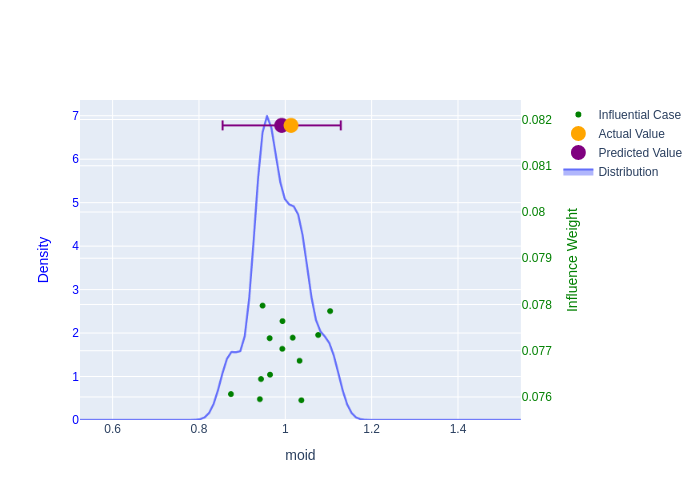

In [10]:
plot_interpretable_prediction(
    react,
    actual_value=action_value,
    generative_reacts=gen_reacts,
    residual=global_residual,
)

## Non-visual interpretation

Howso Engine provides a number of tools for interpreting reacts. Below, we compare the MDA (Mean Decrease in Accuracy) for the predicted case and the original case.

In [11]:
react = trainee.react(context_features=context_features,
                      action_features=action_feature,
                      contexts=[context_values],
                      details = {
                         'feature_mda': True,
                         'robust_influences': True
                      })

loc_mda = react['details']['feature_mda']

mda_dict = dict(sorted(loc_mda[0].items(), key=lambda item: item[1], reverse=True))
mda_df = pd.DataFrame(columns=['original', 'predicted'])
mda_df['predicted'] = mda_dict.values()
mda_df.index = mda_dict.keys()

react2 = trainee.react(context_features=context_features,
                       action_features=action_feature,
                       actions=[[action_value]],  # specify "actual" actual value
                       contexts=[context_values],
                       details = { 
                           'feature_mda_ex_post': True,
                           'robust_influences': True
                       })

loc_mda_post_facto = react2['details']['feature_mda_ex_post']
mda_dict = dict(sorted(loc_mda_post_facto[0].items(), key=lambda item: item[1], reverse=True))
mda_df['original'] = mda_dict.values()

display(mda_df)

,original,predicted
q,0.013029,0.019433
per_y,0.006465,0.017865
e,0.005379,0.017789
IR,0.005308,0.015702
spec_T,0.003308,0.012868
ad,0.003082,0.011469
condition_code,0.002137,0.011449
H,0.000859,0.010811
diameter,0.000711,0.009873
om,-0.000324,0.009501
